# **A Reliable and Accurate Indoor Localization Method Using Phone Inertial Sensors**

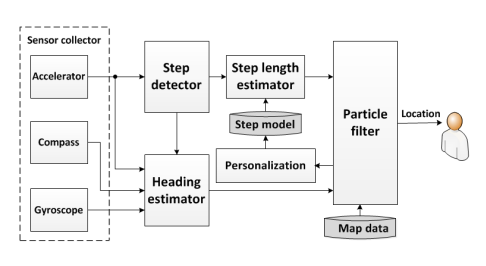

The system is comprised of following mod-
ules, 


1.   step detector 
2.   step length estimator
3.   heading estimator
4.   particle filter
5.   personalization module (for adapting
a step model to an individual user)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns

# **Step Detection**

By walking on a determined path, the Z value of accelerometer will change by the time of it moving or tilting

In [ ]:
accelero_file = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/particle_filter/linacce.csv")
accelero_data_set = pd.DataFrame(accelero_file)
accelero_data_set.head()

,X,Y,Z
0,-0.012726,-0.011488,0.008525
1,-0.057637,-0.030068,-0.014908
2,-0.081502,-0.030228,-0.007234
3,-0.086373,-0.017785,0.034522
4,-0.056592,0.015503,0.064480


In [ ]:
accelero_data_set["Z"].head()

0    0.008525
1   -0.014908
2   -0.007234
3    0.034522
4    0.064480
Name: Z, dtype: float64

In [ ]:
accelero_data_set.describe()


,X,Y,Z
count,157379.000000,157379.000000,157379.000000
mean,0.016595,-0.089382,-0.020387
std,1.373530,1.287095,1.605275
min,-10.656289,-14.759783,-16.027593
25%,-0.526192,-0.518861,-0.690195
50%,0.020204,0.006833,-0.001917
75%,0.656702,0.533808,0.646166
max,17.820326,7.364527,18.921857


In [ ]:
#Need to use this data
accelero_data_set['accelaration_magnitude'] = np.linalg.norm([accelero_data_set['X'],accelero_data_set['Y'],accelero_data_set['Z']]) 


In [ ]:
accelero_data_set['accelaration_magnitude'].head()

0    982.107833
1    982.107833
2    982.107833
3    982.107833
4    982.107833
Name: accelaration_magnitude, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


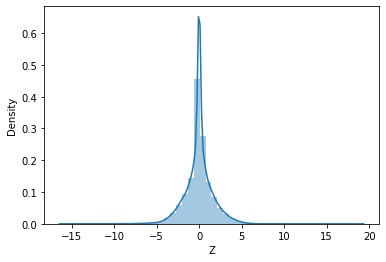

In [ ]:
sns.distplot(accelero_data_set["Z"])

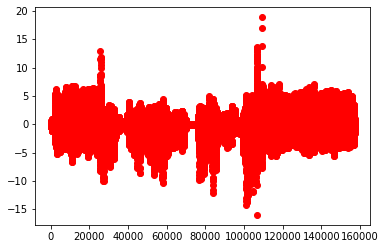

In [ ]:
plt.scatter(accelero_data_set["Z"].index,accelero_data_set["Z"], c="red", label = "Accelaration")

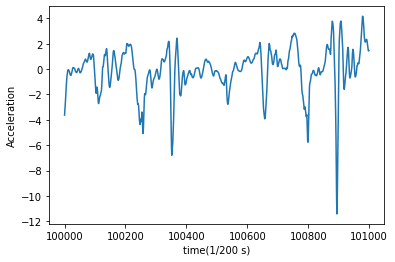

In [ ]:
plot_data = accelero_data_set["Z"][100000:101000]
plot_data.plot(y='Acceleration', use_index=True)
plt.xlabel("time(1/200 s)")  
plt.ylabel("Acceleration")  
plt.show()

In [ ]:
accelero_data_set["Z"].describe()

count    157379.000000
mean         -0.020387
std           1.605275
min         -16.027593
25%          -0.690195
50%          -0.001917
75%           0.646166
max          18.921857
Name: Z, dtype: float64

In [ ]:

def readStepDetection(accelLinearData):
  #Step boundaries
  lastAccelZValue = -9999
  lastCheckTime = 0

  highLineState = True
  lowLineState = True
  passageState = False #moving state

  highLine = 1
  highBoundaryLine = 0
  highBoundaryLineAlpha = 1.0

  highLineMin = 0.50
  highLineMax = 1.5
  highLineAlpha = 0.0005

  lowLine = -1
  lowBoundaryLine = 0
  lowBoundaryLineAlpha = -1.0

  lowLineMax = -0.50
  lowLineMin = -1.5
  lowLineAlpha = 0.0005

  lowPassFilterAlpha = 0.9 
  rotationData =float(9)
  resultData =float(3)
  timeMultiplier = 1/200  # sensor data is at 200Hz

  

  stepIndexes = []

  for i in range(len(accelLinearData)):    
    currentTime = i * timeMultiplier
    gapTime1 = (currentTime - lastCheckTime)
    if (lastAccelZValue == -9999):
      lastAccelZValue = accelLinearData[0]
    
    if (highLineState and highLine > highLineMin):
      highLine = highLine - highLineAlpha
      highBoundaryLine = highLine * highBoundaryLineAlpha
    
    if (lowLineState and lowLine < lowLineMax):
      lowLine = lowLine + lowLineAlpha
      lowBoundaryLine = lowLine * lowBoundaryLineAlpha #?
    # perform a low pass filter for sensor reading
    zValue = (lowPassFilterAlpha * lastAccelZValue) + (1 -lowPassFilterAlpha) * accelLinearData[i]
    if (highLineState and gapTime1 > 1 and zValue > highBoundaryLine):
      highLineState = False
    
    if (lowLineState and zValue < lowBoundaryLine and passageState):
      lowLineState = False

    if (highLineState == False):
      if (zValue > highLine):
        highLine = zValue
        highBoundaryLine = highLine * highBoundaryLineAlpha
        
        if (highLine > highLineMax):
          highLine = highLineMax
          highBoundaryLine = highLine * highBoundaryLineAlpha
      else:
        if (highBoundaryLine > zValue):
          highLineState = True
          passageState = True

    if (lowLineState == False and passageState):
      if (zValue < lowLine):
        lowLine = zValue
        lowBoundaryLine = lowLine * lowBoundaryLineAlpha      
        if (lowLine < lowLineMin):
          lowLine = lowLineMin
          lowBoundaryLine = lowLine * lowBoundaryLineAlpha
      else:
          if (lowBoundaryLine < zValue):
            lowLineState = True
            passageState = False
            
            stepIndexes.append(i)            
            lastCheckTime = currentTime  
    lastAccelZValue = zValue
  return stepIndexes

In [ ]:
steps = readStepDetection(np.array(accelero_data_set["Z"]))
print([i / (200) for i in steps])
len(steps)

[11.35, 11.975, 13.7, 14.26, 15.805, 15.93, 17.445, 17.975, 19.505, 20.12, 21.825, 22.27, 23.865, 24.41, 26.175, 26.615, 27.815, 28.285, 29.895, 30.545, 32.17, 33.755, 34.205, 35.845, 36.37, 38.03, 38.575, 40.18, 40.765, 42.48, 42.56, 44.115, 44.69, 46.325, 46.885, 48.06, 49.145, 50.27, 51.86, 52.435, 54.105, 54.655, 56.325, 56.42, 57.49, 58.585, 60.145, 60.665, 61.87, 62.43, 64.02, 65.25, 65.72, 67.365, 67.455, 69.085, 69.54, 71.68, 72.46, 73.83, 74.415, 75.655, 77.625, 78.14, 79.325, 80.8, 80.97, 82.525, 83.085, 84.415, 86.46, 86.94, 88.495, 88.64, 90.175, 90.755, 92.455, 92.565, 94.26, 94.735, 96.495, 97.01, 98.85, 99.34, 101.11, 101.555, 103.215, 103.305, 104.985, 105.465, 106.675, 107.155, 108.425, 108.94, 110.15, 111.325, 113.055, 113.56, 114.8, 115.255, 116.5, 117.1, 118.265, 119.84, 120.49, 121.645, 122.24, 123.865, 124.41, 125.635, 126.34, 127.75, 127.84, 129.355, 135.945, 136.545, 138.215, 139.505, 140.145, 144.55, 144.925, 150.43, 152.315, 152.975, 156.005, 161.495, 202.245,

458

# **Position update and personalization**

To track motion: we need to maintain states for x, y, and heading.

# **Particle filter**

In [ ]:
#1 --> Uniform particles
from numpy.random import uniform
# creates a uniform and Gaussian distribution of particles over a region

def create_uniform_particles(x_range, y_range, hdg_range, N): # (x,y,heading)
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N) 
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(hdg_range[0], hdg_range[1], size=N)
    particles[:, 2] %= 2 * np.pi
    return particles

def create_gaussian_particles(mean, std, N):
    particles = np.empty((N, 3))
    particles[:, 0] = mean[0] + (np.randn(N) * std[0])
    particles[:, 1] = mean[1] + (np.randn(N) * std[1])
    particles[:, 2] = mean[2] + (np.randn(N) * std[2])
    particles[:, 2] %= 2 * np.pi
    return particles


In [ ]:
img = plt.imread("/content/drive/MyDrive/Colab Notebooks/particle_filter/coquitlum_01.png") 

In [ ]:
# Use odometry to predict (heading direction, step size)
def predict(particles, u, std, dt=1.):
    """ move according to  (heading change, step size)
    with noise Q (std heading change, std step size)`"""

    N = len(particles)
    # update heading
    particles[:, 2] += u[0] + (np.random.randn(N) * std[0])
    particles[:, 2] %= 2 * np.pi

    # move in the (noisy) commanded direction
    dist = (u[1] * dt) + (np.random.randn(N) * std[1])
    particles[:, 0] += np.cos(particles[:, 2]) * dist
    particles[:, 1] += np.sin(particles[:, 2]) * dist

In [ ]:
#get a set of measurements - one for each landmark currently in view(co ordinates for map)
def update(particles, weights, z, R, landmarks): 
    for i, landmark in enumerate(landmarks):
        distance = np.linalg.norm(particles[:, 0:2] - landmark, axis=1)
        weights *= scipy.stats.norm(distance, R).pdf(z[i])

    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize

In [ ]:
def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""

    pos = particles[:, 0:2]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var

In [ ]:
def simple_resample(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, np.random(N))

    # resample according to indexes
    particles[:] = particles[indexes]
    weights.fill(1.0 / N)

In [ ]:
particles = create_uniform_particles((0,1), (0,1), (0, 5), 1000)
weights = np.array([.25]*1000)
estimate(particles, weights)

(array([0.5114257 , 0.49244089]), array([0.08334035, 0.0831279 ]))

In [ ]:
def neff(weights):
    return 1. / np.sum(np.square(weights))

In [ ]:
def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill (1.0 / len(weights))

final position error, variance:
	 [-0.09525942  0.08813509] [0.01078074 0.0068301 ]


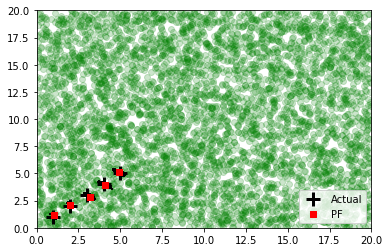

In [ ]:
def run_pf1(N, iters=5, sensor_std_err=.1, 
            do_plot=True, plot_particles=False,
            xlim=(0, 20), ylim=(0, 20),
            initial_x=None):
    landmarks = np.array([[-1, 2], [5, 10], [12,14], [18,21]]) # need to get from map (1)
    NL = len(landmarks)
    
    plt.figure()
   
    # create particles and weights
    if initial_x is not None:
        particles = create_gaussian_particles(
            mean=initial_x, std=(5, 5, np.pi/4), N=N)
    else:
        particles = create_uniform_particles((0,20), (0,20), (0, 6.28), N)
    weights = np.ones(N) / N

    if plot_particles:
        alpha = .20
        if N > 5000:
            alpha *= np.sqrt(5000)/np.sqrt(N)           
        plt.scatter(particles[:, 0], particles[:, 1],  #(x,y)
                    alpha=alpha, color='g')
    
    xs = []
    robot_pos = np.array([0., 0.])
    for x in range(iters):
        robot_pos += (1, 1)

        # distance from robot to each landmark
        zs = (np.linalg.norm(landmarks - robot_pos, axis=1) + 
              (np.random.randn(NL) * sensor_std_err))

        # move diagonally forward to (x+1, x+1) (2 : towards heading direction)
        predict(particles, u=(0.00, 1.414), std=(.2, .05))
        
        # incorporate measurements (3: absolut locations)
        update(particles, weights, z=zs, R=sensor_std_err, 
               landmarks=landmarks)
        
        # resample if too few effective particles
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)
        mu, var = estimate(particles, weights)
        xs.append(mu)

        if plot_particles:
            plt.scatter(particles[:, 0], particles[:, 1], 
                        color='k', marker=',', s=1)
        p1 = plt.scatter(robot_pos[0], robot_pos[1], marker='+',
                         color='k', s=180, lw=3)
        p2 = plt.scatter(mu[0], mu[1], marker='s', color='r')
    
    xs = np.array(xs)
    #plt.plot(xs[:, 0], xs[:, 1])
    plt.legend([p1, p2], ['Actual', 'PF'], loc=4, numpoints=1)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    print('final position error, variance:\n\t', mu - np.array([iters, iters]), var)
    plt.show()

np.random.seed(2) 
run_pf1(N=5000, plot_particles=True)